In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from sklearn.impute import SimpleImputer

C:\Users\nikit\AppData\Local\Temp\ipykernel_21668\4080024128.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_monthly = ts.resample('M').sum()


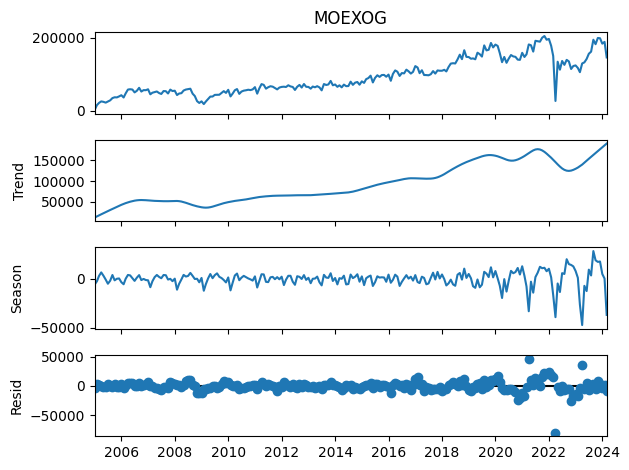

In [3]:
data = pd.read_csv('./data/data_indexes_moex.csv', index_col=0)
data.index = pd.to_datetime(data.index)

ts = data['MOEXOG'].interpolate(method='time')

# Преобразование ежедневных данных в месячные, используя значение за месяц
ts_monthly = ts.resample('M').sum()

decompose = STL(ts_monthly)
result = decompose.fit()

# Получим компоненты ряда
trend = result.trend
seasonal = result.seasonal
residual = result.resid

result.plot()
plt.show()

In [4]:
# Обработка пропущенных значений в данных тренда и остатков.
residual = residual.fillna(residual.mean())
seasonal = seasonal.fillna(seasonal.mean())
trend = trend.fillna(trend.mean())

In [5]:
###################################################################################
# Модель прогнозирования тренда (линейная регрессия)
trend_model = LinearRegression()
lags_trend = np.array([trend.shift(i) for i in range(1, len(trend) + 1)]).T[1:]
lags_trend = np.nan_to_num(lags_trend)
trend_model.fit(lags_trend, trend[1:])

# Модель прогнозирования сезонности (автоматический подбор параметров ARIMA)
seasonal_model = auto_arima(seasonal)

# Модель прогнозирования остатков (градиентный бустинг)
residual_model = GradientBoostingRegressor()
lags_residual = np.array([residual.shift(i) for i in range(1, len(residual) + 1)]).T[1:]
lags_residual = np.nan_to_num(lags_residual)
residual_model.fit(lags_residual, residual[1:])

GradientBoostingRegressor()

In [6]:
# Создание массива lags_trend_forecast для прогнозирования тренда
lags_trend_forecast = np.array([trend.shift(i) for i in range(1, len(trend) + 1)]).T[1:]
lags_trend_forecast = np.nan_to_num(lags_trend_forecast)
trend_forecast = trend_model.predict(lags_trend_forecast)

# Прогнозирование сезонности
seasonal_forecast = seasonal_model.predict(n_periods=len(ts_monthly))

# Прогнозирование остатков
lags_residual_forecast = np.array([residual.shift(i) for i in range(1, len(residual) + 1)]).T[1:]
lags_residual_forecast = np.nan_to_num(lags_residual_forecast)
residual_forecast = residual_model.predict(lags_residual_forecast)

In [10]:
###################################################################################
# Общий прогноз
total_forecast = trend_forecast + seasonal_forecast[1:] + residual_forecast

###################################################################################
# Оценим модель

# Фактические значения
actual_values = ts_monthly[-len(total_forecast):]

# Вычисление среднеквадратичной ошибки (MSE)
mse = mean_squared_error(actual_values, total_forecast)
print("Mean Squared Error (MSE):", mse)

# Вычисление корня из среднеквадратичной ошибки (RMSE)
rmse = np.sqrt(mean_squared_error(actual_values, total_forecast))
print("Mean Squared Error (RMSE):", rmse)

# Вычисление средней абсолютной ошибки (MAE)
mae = mean_absolute_error(actual_values, total_forecast)
print("Mean Absolute Error (MAE):", mae)

# Вычисление коэффициента детерминации (R^2)
r2 = r2_score(actual_values, total_forecast)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 367879068.5007941
Mean Squared Error (RMSE): 19180.173839170337
Mean Absolute Error (MAE): 16513.64678025315
R^2 Score: 0.8421587020935333


In [8]:
#Тут чето не то...(а может так и должно быть...)
print("R^2 Score:", r2_score(residual[1:], residual_forecast))
print("R^2 Score:", r2_score(seasonal, seasonal_forecast))
print("R^2 Score:", r2_score(trend[1:], trend_forecast))

R^2 Score: 0.9896100243474323
R^2 Score: -4.436184293975265
R^2 Score: 1.0


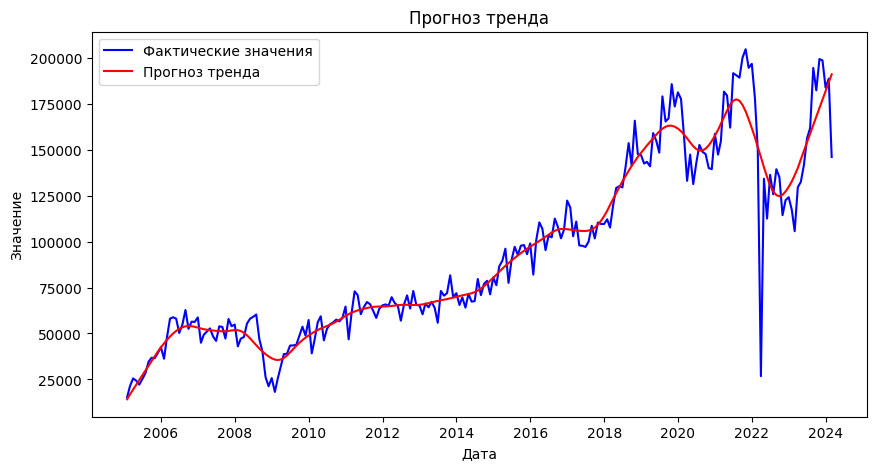

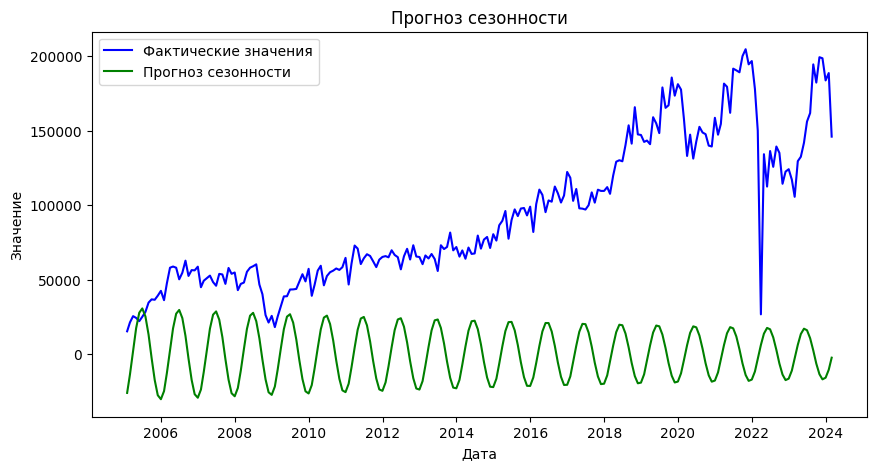

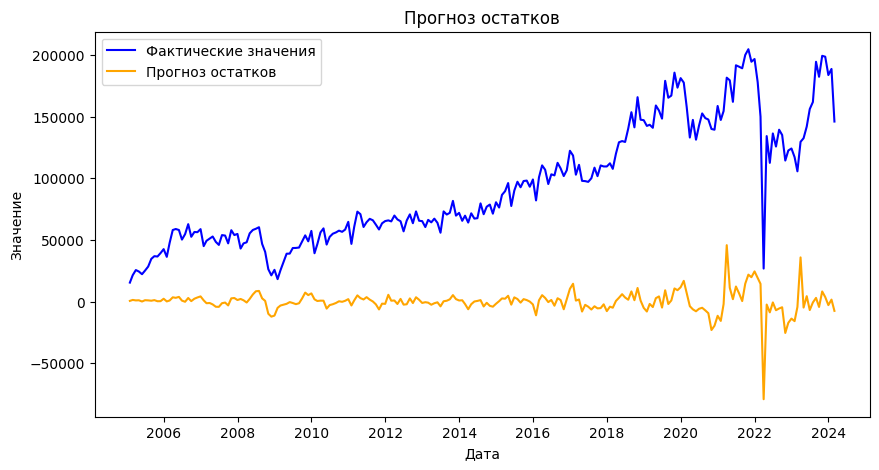

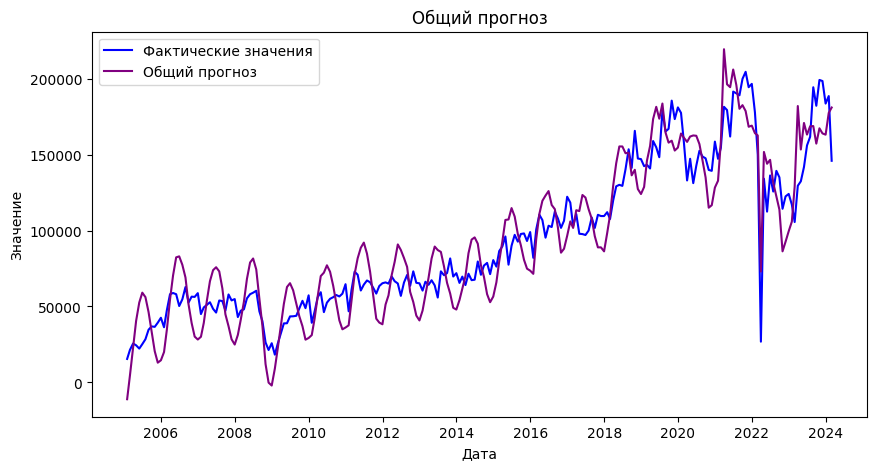

In [9]:
# Построим графики по фактическим значениям и прогнозам по компонентам
# График тренда
plt.figure(figsize=(10, 5))
plt.plot(actual_values.index, actual_values, label='Фактические значения', color='blue')
plt.plot(actual_values.index, trend_forecast, label='Прогноз тренда', color='red')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Прогноз тренда')
plt.legend()
plt.show()

# График сезонности
plt.figure(figsize=(10, 5))
plt.plot(actual_values.index, actual_values, label='Фактические значения', color='blue')
plt.plot(actual_values.index, seasonal_forecast[1:], label='Прогноз сезонности', color='green')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Прогноз сезонности')
plt.legend()
plt.show()

# График остатков
plt.figure(figsize=(10, 5))
plt.plot(actual_values.index, actual_values, label='Фактические значения', color='blue')
plt.plot(actual_values.index, residual_forecast, label='Прогноз остатков', color='orange')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Прогноз остатков')
plt.legend()
plt.show()

# График общего прогноза
plt.figure(figsize=(10, 5))
plt.plot(actual_values.index, actual_values, label='Фактические значения', color='blue')
plt.plot(actual_values.index, total_forecast, label='Общий прогноз', color='purple')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Общий прогноз')
plt.legend()
plt.show()

In [12]:
# Что надо доделать:
# Добавить МАПЕ к оценкам модели
# Попробовать градиентный бустинг не из склерна
# Разобраться с R^2 по компонентам и их предсказаниям (выглядит очень подозрительно при том, что остатки и сезонность вообще полностью совпадают). А если это норм, то надо бы понять
# как это интерпретировать...